# Промышленность — задача проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

### План работы

1. Изучение и подготовка данных:
* Выгрузка данных
* Описание данных
2. Предобработка данных:
* Проверка типов данных
* Работа с проспусками
3. Подготовка данных:
* Формирование итоговых датафреймов
* Формирование целевого и остальных признаков
* Формирвоание обучающих и тест выборок
4. Обучение моделей:
* 3-4 модели
5. Тестирование моделей
6. Итоговый вывод

In [1]:
import pandas as pd
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

### Выгрузка данных

In [2]:
pth1 = '/datasets/final_steel/data_arc.csv'
pth2 = 'data_arc.csv'

if os.path.exists(pth1):
    data_arc = pd.read_csv(pth1)
elif os.path.exists(pth2):
    data_arc = pd.read_csv(pth2)
else:
    print('Не верный путь') 

In [3]:
data_arc.head(5)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [4]:
pth1 = '/datasets/final_steel/data_bulk.csv'
pth2 = 'data_bulk.csv'

if os.path.exists(pth1):
    data_bulk = pd.read_csv(pth1)
elif os.path.exists(pth2):
    data_bulk = pd.read_csv(pth2)
else:
    print('Не верный путь') 

In [5]:
data_bulk.head(5)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


Присутствуют пропуски, но это связано с тех процессом, позже заменим на 0

In [6]:
pth1 = '/datasets/final_steel/data_gas.csv'
pth2 = 'data_gas.csv'

if os.path.exists(pth1):
    data_gas = pd.read_csv(pth1)
elif os.path.exists(pth2):
    data_gas = pd.read_csv(pth2)
else:
    print('Не верный путь') 

In [7]:
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [8]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [9]:
data_gas.isna().sum()

key      0
Газ 1    0
dtype: int64

In [10]:
data_gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


In [11]:
pth1 = '/datasets/final_steel/data_temp.csv'
pth2 = 'data_temp.csv'

if os.path.exists(pth1):
    data_temp = pd.read_csv(pth1)
elif os.path.exists(pth2):
    data_temp = pd.read_csv(pth2)
else:
    print('Не верный путь') 

In [12]:
data_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [13]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [14]:
data_temp.isna().sum()

key                0
Время замера       0
Температура     2901
dtype: int64

Удаляем пропуски в данных по температуре

In [15]:
data_temp = data_temp.dropna()

In [16]:
pth1 = '/datasets/final_steel/data_wire.csv'
pth2 = 'data_wire.csv'

if os.path.exists(pth1):
    data_wire = pd.read_csv(pth1)
elif os.path.exists(pth2):
    data_wire = pd.read_csv(pth2)
else:
    print('Не верный путь') 

In [17]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Так же присутствуют пропуски связанные с тех процессом, заменим на 0

Данные загружены, не загружались data_bulk_time и data_wire_time, так как они не важны для анализа

### Предобработка данных

In [18]:
#заполнил пропуски 0
data_bulk = data_bulk.fillna(0)
#data_wire = data_bulk.fillna(0)
data_wire = data_wire.fillna(0)

In [19]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [20]:
#Привел к необходимому формату даты
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'], format='%Y-%m-%dT%H:%M:%S')
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'], format='%Y-%m-%dT%H:%M:%S')

In [21]:
data_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


Присутствует выброс в виде отрицательных значений реактивной мощьности.

In [22]:
data_arc = data_arc[data_arc['Реактивная мощность']>=0] #избавился от аномалии

Корреляция Активной и Реактивной мощности 0.9631819131519801


<Figure size 1440x720 with 0 Axes>

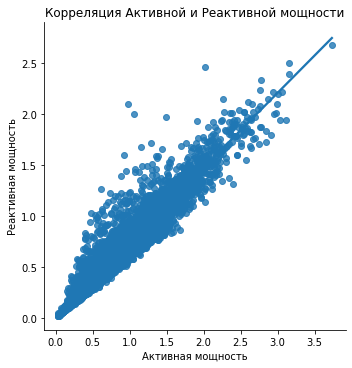

In [23]:
print('Корреляция Активной и Реактивной мощности', data_arc['Активная мощность'].corr(data_arc['Реактивная мощность']))
plt.figure(figsize=(20,10))
sns.lmplot(x='Активная мощность', y='Реактивная мощность', data=data_arc)
plt.title('Корреляция Активной и Реактивной мощности')
plt.show()

Кореляция Активной мощьности к Реактивной почти равна 1, нужно использовать полную мощность

In [24]:
data_arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768


In [25]:
def time(row):
        
    time= row['Конец нагрева дугой'] - row['Начало нагрева дугой']
    return time

In [26]:
data_arc['Время нагрева'] = data_arc.apply(time, axis=1)

In [27]:
data_arc_sum = data_arc.groupby('key').agg(t = ('Время нагрева', 'sum'),
                                           p = ('Активная мощность', 'sum'),
                                           r = ('Реактивная мощность', 'sum'))

In [28]:
data_arc_sum['s'] = np.sqrt(data_arc_sum['p']**2 + data_arc_sum['r']**2)

In [29]:
data_arc_sum = data_arc_sum.rename_axis('key').reset_index()

In [30]:
data_arc_sum

,key,t,p,r,s
0,1,0 days 00:18:18,4.878147,3.183241,5.824889
1,2,0 days 00:13:31,3.052598,1.998112,3.648398
2,3,0 days 00:10:55,2.525882,1.599076,2.989502
3,4,0 days 00:12:21,3.209250,2.060298,3.813674
4,5,0 days 00:14:29,3.347173,2.252643,4.034596
...,...,...,...,...,...
3209,3237,0 days 00:15:09,3.932467,2.828459,4.844014
3210,3238,0 days 00:09:06,2.106529,1.681182,2.695151
3211,3239,0 days 00:20:16,4.666754,3.111617,5.608989
3212,3240,0 days 00:13:59,2.984083,2.483267,3.882186


In [31]:
count = data_temp.groupby(by = 'key', as_index=False).count()
one = count[count['Время замера']== 1]['key'].tolist()
data_temp = data_temp.query('key not in @one')

In [32]:
data_target = data_temp.groupby(by = 'key', as_index = False).agg(['first', 'last'])

In [33]:
data_target.columns = ['time_first', 'time_last', 'temp_first', 'temp_last']

In [34]:
data_target

,time_first,time_last,temp_first,temp_last
key,,,,
1,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1613.0
2,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0,1602.0
3,2019-05-03 12:13:17,2019-05-03 12:34:57,1596.0,1599.0
4,2019-05-03 12:52:57,2019-05-03 12:59:25,1601.0,1625.0
5,2019-05-03 13:23:19,2019-05-03 13:36:01,1576.0,1602.0
...,...,...,...,...
2495,2019-08-06 00:35:45,2019-08-06 00:54:42,1570.0,1591.0
2496,2019-08-06 01:02:54,2019-08-06 01:29:52,1554.0,1591.0
2497,2019-08-06 01:41:53,2019-08-06 01:53:50,1571.0,1589.0


In [35]:
data_target.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 1 to 2499
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   time_first  2475 non-null   object 
 1   time_last   2475 non-null   object 
 2   temp_first  2475 non-null   float64
 3   temp_last   2475 non-null   float64
dtypes: float64(2), object(2)
memory usage: 96.7+ KB


In [36]:
df = data_target.merge(data_gas, how = 'inner', on = 'key')

In [37]:
df

,key,time_first,time_last,temp_first,temp_last,Газ 1
0,1,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1613.0,29.749986
1,2,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0,1602.0,12.555561
2,3,2019-05-03 12:13:17,2019-05-03 12:34:57,1596.0,1599.0,28.554793
3,4,2019-05-03 12:52:57,2019-05-03 12:59:25,1601.0,1625.0,18.841219
4,5,2019-05-03 13:23:19,2019-05-03 13:36:01,1576.0,1602.0,5.413692
...,...,...,...,...,...,...
2468,2495,2019-08-06 00:35:45,2019-08-06 00:54:42,1570.0,1591.0,7.125735
2469,2496,2019-08-06 01:02:54,2019-08-06 01:29:52,1554.0,1591.0,9.412616
2470,2497,2019-08-06 01:41:53,2019-08-06 01:53:50,1571.0,1589.0,6.271699
2471,2498,2019-08-06 02:03:49,2019-08-06 02:25:31,1591.0,1594.0,14.953657


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2473 entries, 0 to 2472
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         2473 non-null   int64  
 1   time_first  2473 non-null   object 
 2   time_last   2473 non-null   object 
 3   temp_first  2473 non-null   float64
 4   temp_last   2473 non-null   float64
 5   Газ 1       2473 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 135.2+ KB


In [39]:
df = df.merge(data_arc_sum,how = 'inner')

In [40]:
df = df.merge(data_wire,how = 'inner')

In [41]:
df = df.merge(data_bulk,how = 'inner')

In [42]:
df.head()

,key,time_first,time_last,temp_first,temp_last,Газ 1,t,p,r,s,...,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1613.0,29.749986,0 days 00:18:18,4.878147,3.183241,5.824889,...,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0,1602.0,12.555561,0 days 00:13:31,3.052598,1.998112,3.648398,...,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,2019-05-03 12:13:17,2019-05-03 12:34:57,1596.0,1599.0,28.554793,0 days 00:10:55,2.525882,1.599076,2.989502,...,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,2019-05-03 12:52:57,2019-05-03 12:59:25,1601.0,1625.0,18.841219,0 days 00:12:21,3.209250,2.060298,3.813674,...,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,2019-05-03 13:23:19,2019-05-03 13:36:01,1576.0,1602.0,5.413692,0 days 00:14:29,3.347173,2.252643,4.034596,...,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 34 columns):
 #   Column      Non-Null Count  Dtype          
---  ------      --------------  -----          
 0   key         2329 non-null   int64          
 1   time_first  2329 non-null   object         
 2   time_last   2329 non-null   object         
 3   temp_first  2329 non-null   float64        
 4   temp_last   2329 non-null   float64        
 5   Газ 1       2329 non-null   float64        
 6   t           2329 non-null   timedelta64[ns]
 7   p           2329 non-null   float64        
 8   r           2329 non-null   float64        
 9   s           2329 non-null   float64        
 10  Wire 1      2329 non-null   float64        
 11  Wire 2      2329 non-null   float64        
 12  Wire 3      2329 non-null   float64        
 13  Wire 4      2329 non-null   float64        
 14  Wire 5      2329 non-null   float64        
 15  Wire 6      2329 non-null   float64        
 16  Wire 7

In [44]:
df['t'] = df['t'].dt.seconds

In [45]:
df.head()

,key,time_first,time_last,temp_first,temp_last,Газ 1,t,p,r,s,...,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1613.0,29.749986,1098,4.878147,3.183241,5.824889,...,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0,1602.0,12.555561,811,3.052598,1.998112,3.648398,...,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,2019-05-03 12:13:17,2019-05-03 12:34:57,1596.0,1599.0,28.554793,655,2.525882,1.599076,2.989502,...,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,2019-05-03 12:52:57,2019-05-03 12:59:25,1601.0,1625.0,18.841219,741,3.209250,2.060298,3.813674,...,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,2019-05-03 13:23:19,2019-05-03 13:36:01,1576.0,1602.0,5.413692,869,3.347173,2.252643,4.034596,...,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


In [46]:
df.isna().sum()

key           0
time_first    0
time_last     0
temp_first    0
temp_last     0
Газ 1         0
t             0
p             0
r             0
s             0
Wire 1        0
Wire 2        0
Wire 3        0
Wire 4        0
Wire 5        0
Wire 6        0
Wire 7        0
Wire 8        0
Wire 9        0
Bulk 1        0
Bulk 2        0
Bulk 3        0
Bulk 4        0
Bulk 5        0
Bulk 6        0
Bulk 7        0
Bulk 8        0
Bulk 9        0
Bulk 10       0
Bulk 11       0
Bulk 12       0
Bulk 13       0
Bulk 14       0
Bulk 15       0
dtype: int64

Пропуски отсутствуют

df = df.dropna()

df.isna().sum()

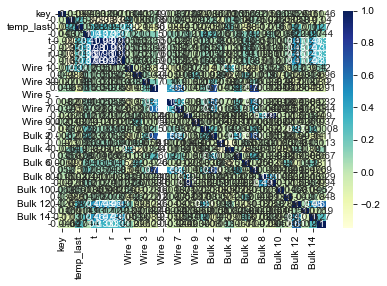

<Figure size 1080x576 with 0 Axes>

In [47]:
df_plot = sns.heatmap(df.corr(), cmap="YlGnBu", annot=True) 
sns.set(rc = {'figure.figsize':(20,10)})
plt.figure(figsize = (15,8))
plt.show()

### Вывод
Видно что данные используещиеся в подсчете полной мощьности сильно коррелирует, оставляю только итоговую полную мощьность.

Так же убираю номера партий и время замеров.

In [48]:
df = df.drop(['key','time_first','time_last','p','r','t'], axis = 1)

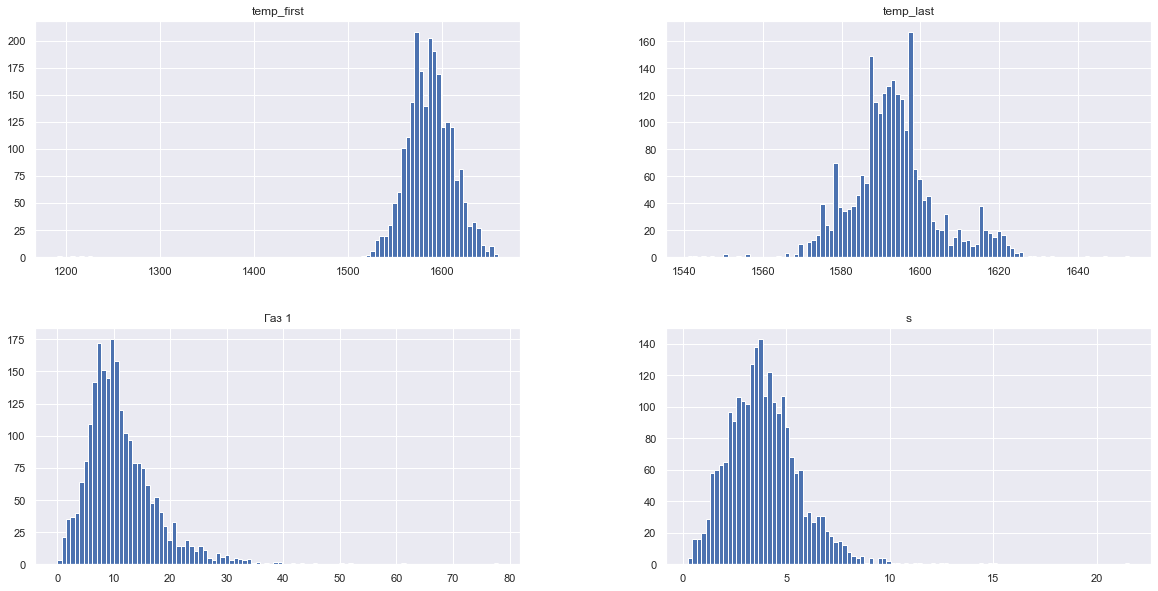

In [49]:
hist = df[['temp_first','temp_last','Газ 1','s']].hist(bins=100)

По распределению в целом все в порядке, присутствуют выбросы, но нужно уточнять норма это или нет.

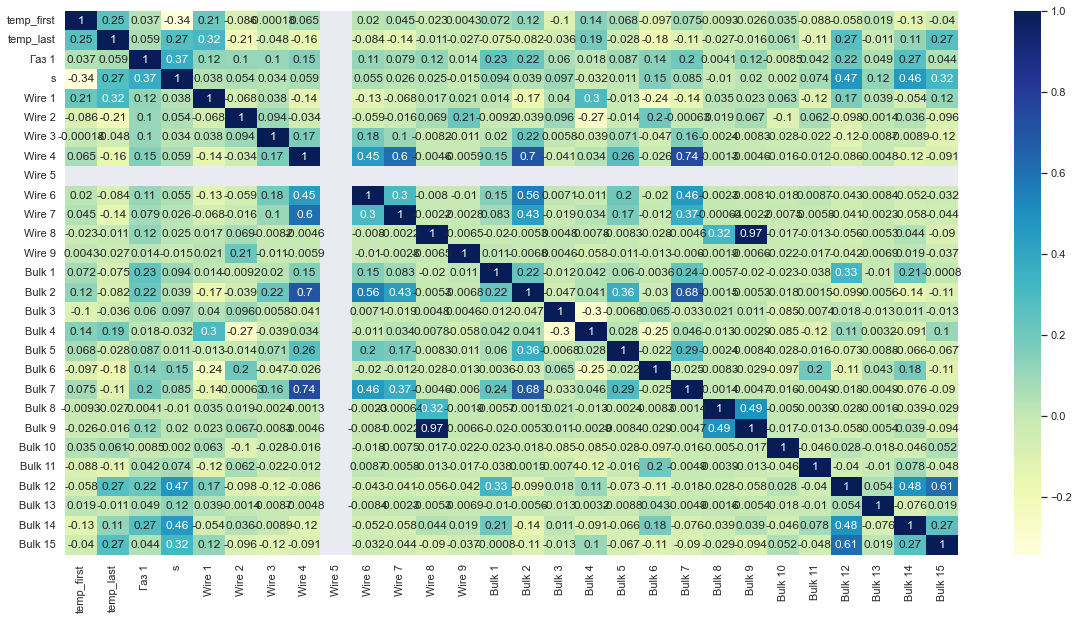

<Figure size 1080x576 with 0 Axes>

In [50]:
df_plot = sns.heatmap(df.corr(), cmap="YlGnBu", annot=True) 
sns.set(rc = {'figure.figsize':(20,10)})
plt.figure(figsize = (15,8))

plt.show()

Вполне себе нормальная матрица корреляции без явных перекосов.

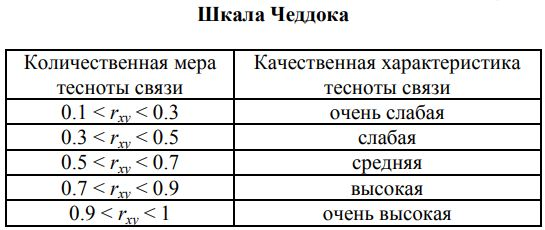

In [51]:
df.describe()

,temp_first,temp_last,Газ 1,s,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,...,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.0,2329.000000,...,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000
mean,1586.718763,1593.365393,11.375600,3.938257,102.443601,17.609859,3.234916,0.306550,0.0,0.978820,...,22.430228,2.004723,0.021039,0.444826,5.052812,4.245170,208.415629,1.067411,153.853585,119.952769
std,28.290792,11.200915,6.392041,1.776694,43.539993,33.624771,27.942871,4.757746,0.0,8.693299,...,55.790873,30.676234,1.015340,6.220641,20.917800,22.515487,157.062272,14.235055,81.404354,84.640443
min,1191.000000,1541.000000,0.008399,0.257637,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1571.000000,1587.000000,7.282948,2.732395,73.207679,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,105.000000,0.000000
50%,1587.000000,1593.000000,10.100950,3.773305,101.119201,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,149.000000,107.000000
75%,1603.000000,1598.000000,14.216688,4.874603,128.091599,23.102560,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,282.000000,0.000000,204.000000,204.000000
max,1660.000000,1653.000000,77.995040,21.554231,330.314424,282.780152,385.008668,113.231044,0.0,180.454575,...,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


### Обучение моделей

In [52]:
random_state = 31102022
cv_counts = 8

In [53]:
y = df['temp_last'] # Таргет
x = df.drop(['temp_last'], axis = 1) # Признаки

In [54]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = random_state)

In [55]:
xx_train = x_train
xx_test = x_test
yy_train = y_train
yy_test = y_test

In [56]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

##### LinearRegression

In [57]:
%%time
regressor = LinearRegression()
print()
cv_MAE_LR = (cross_val_score(regressor, 
                             x_train, 
                             y_train, 
                             cv=cv_counts, 
                             scoring='neg_mean_absolute_error').mean() * -1)
print('MAE на обучающей выборке =', cv_MAE_LR)


MAE на обучающей выборке = 6.469333295330472
Wall time: 47 ms


##### RandomForestRegressor

In [58]:
%%time

regressor = RandomForestRegressor(random_state=random_state) 
hyperparams = [{'n_estimators':[x for x in range(50, 701, 50)]}]

print('# Подбор гиперпараметров')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_absolute_error', cv=cv_counts,n_jobs=-1)
clf.fit(x_train, y_train)
print("Лучшие гиперпараметры:")
print()
best_params_RFR = clf.best_params_
print(clf.best_params_)
print()
print("Показатель MAE при подборе гиперпараметров:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1), params))
print()

cv_MAE_RFR = (max(means)*-1)
print('MAE на обучающей выборке =',cv_MAE_RFR)

# Подбор гиперпараметров

Лучшие гиперпараметры:

{'n_estimators': 550}

Показатель MAE при подборе гиперпараметров:

6.204436 for {'n_estimators': 50}
6.128572 for {'n_estimators': 100}
6.118108 for {'n_estimators': 150}
6.114754 for {'n_estimators': 200}
6.110095 for {'n_estimators': 250}
6.110986 for {'n_estimators': 300}
6.108869 for {'n_estimators': 350}
6.105109 for {'n_estimators': 400}
6.098268 for {'n_estimators': 450}
6.096186 for {'n_estimators': 500}
6.089767 for {'n_estimators': 550}
6.089818 for {'n_estimators': 600}
6.092439 for {'n_estimators': 650}
6.095411 for {'n_estimators': 700}

MAE на обучающей выборке = 6.0897669433432
Wall time: 46 s


### CatBoostRegressor

In [59]:
%%time

regressor = CatBoostRegressor(verbose=False, random_state=random_state)
print('# Подбор гиперпараметров')
print()
cv_MAE_CBR = (cross_val_score(regressor, 
                             x_train, 
                             y_train, 
                             cv=cv_counts,
                             n_jobs=-1,
                             scoring='neg_mean_absolute_error').mean() * -1)
print('MAE на обучающей выборке =', cv_MAE_CBR)
print()
print("Лучшие гиперпараметры:")
print()
best_params_CBR = CatBoostRegressor(verbose=False, 
                                    random_state=random_state).fit(x_train, 
                                        y_train).get_all_params()
best_params_CBR

# Подбор гиперпараметров

MAE на обучающей выборке = 6.072156716978467

Лучшие гиперпараметры:

Wall time: 11.1 s


{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'random_seed': 31102022,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'RMSE',
 'learning_rate': 0.04471199959516525,
 'score_function': 'Cosine',
 'tas

### LGBMRegressor

In [60]:
%%time

regressor = LGBMRegressor(random_state=random_state) 
hyperparams = [{'num_leaves':[x for x in range(4,31)], 
                'learning_rate':[x/100 for x in range(1, 11)]}]

print('# Подбор гиперпараметров')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_absolute_error', cv=cv_counts,n_jobs=-1)
clf.fit(x_train, y_train)
print("Лучшие гиперпараметры:")
print()
best_params_LGBMR = clf.best_params_
print(clf.best_params_)
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1), params))
print()


cv_MAE_LGBMR = (max(means)*-1)
print('MAE на обучающей выборке =',cv_MAE_LGBMR)

# Подбор гиперпараметров

Лучшие гиперпараметры:

{'learning_rate': 0.09, 'num_leaves': 13}
7.169574 for {'learning_rate': 0.01, 'num_leaves': 4}
7.073705 for {'learning_rate': 0.01, 'num_leaves': 5}
6.996719 for {'learning_rate': 0.01, 'num_leaves': 6}
6.937769 for {'learning_rate': 0.01, 'num_leaves': 7}
6.889786 for {'learning_rate': 0.01, 'num_leaves': 8}
6.839754 for {'learning_rate': 0.01, 'num_leaves': 9}
6.816359 for {'learning_rate': 0.01, 'num_leaves': 10}
6.793708 for {'learning_rate': 0.01, 'num_leaves': 11}
6.766361 for {'learning_rate': 0.01, 'num_leaves': 12}
6.743920 for {'learning_rate': 0.01, 'num_leaves': 13}
6.723123 for {'learning_rate': 0.01, 'num_leaves': 14}
6.701485 for {'learning_rate': 0.01, 'num_leaves': 15}
6.685918 for {'learning_rate': 0.01, 'num_leaves': 16}
6.674047 for {'learning_rate': 0.01, 'num_leaves': 17}
6.660210 for {'learning_rate': 0.01, 'num_leaves': 18}
6.646615 for {'learning_rate': 0.01, 'num_leaves': 19}
6.645406 for {'learning_rate': 0.0

In [61]:
index = ['LinearRegression',
         'RandomForestRegressor',
         'CatBoostRegressor',
         'LGBMRegressor']

data = {'MAE ntcnjdjq ':[cv_MAE_LR,
                     cv_MAE_RFR,
                     cv_MAE_CBR,
                     cv_MAE_LGBMR]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data

,MAE ntcnjdjq
LinearRegression,6.469333
RandomForestRegressor,6.089767
CatBoostRegressor,6.072157
LGBMRegressor,6.029126


Модель CatBoostRegressor показала себя лучше других на тестовой выборке. 

### Тестировение модели

##### CatBoostRegressor

In [62]:
%%time

model = CatBoostRegressor(verbose=False)
model.set_params(**best_params_CBR)
model.fit(xx_train, yy_train)
y_predict = model.predict(xx_test)
test_MAE_CBR = mean_absolute_error(y_predict, yy_test)
print('Показатель MAE на тестовой выборке', test_MAE_CBR)

Показатель MAE на тестовой выборке 6.041322439283121
Wall time: 2.66 s


In [63]:
def chart_feature_imp(model):
    feature_imp = pd.Series(model.feature_importances_, index=xx_train.columns).sort_values(ascending=False)

    ax = sns.barplot(x=feature_imp, y=feature_imp.index)
    _ = ax.set(xlabel='Оценка важности признаков', ylabel='Признаки')
    _ = ax.set_title('Визуализация важности признаков')

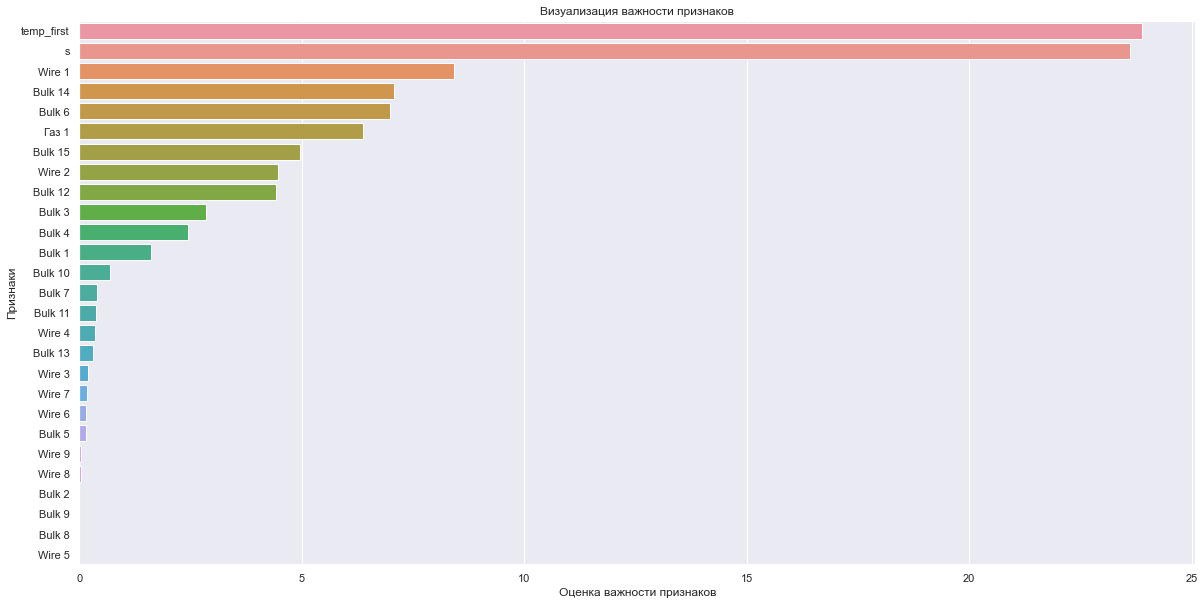

In [64]:
chart_feature_imp(model)

### Вывод
Модель CatBoostRegressor справляется с поставленной задачей, MAE = 6.565


### Общий вывод
1. Проведен исследовательский анализ

2. Обработаны пропуски и выбросы

3. Добавлены новые признаки для обучения модели

4. Для обучения использовались следующие модели
* LinearRegression
* RandomForestRegressor
* CatBoostRegressor
* LGBMRegressor

5. Лучше всего себя показала модель CatBoostRegressor с МАЕ 6.565

- Какие пункты плана были выполнены, а какие — нет (поясните почему)?<br>
- Какие трудности возникли и как вы их преодолели?<br>
- Какие ключевые шаги в решении задачи выделили?<br>
- Какая ваша итоговая модель и какое у неё качество?<br>

### Отчет о проделанной работе

1. Все пункты плана были выполнены.
2. Ключевые этапы это предобработка данных и исследовательский анализ, так как без них не возможно понять какие целевые признаки нужны для обучения модели.
3. Итоговой моделью стала  модель CatBoostRegressor которая дает результат удовлетворяющий условию задачи.
4. Посмотрев переменные во время предобработки данных, увидели что переменные в большенстве случаев количественные и выбросов практически нет, но и от тех что были избавились.

При проведении анализа некоторые переменные оказываются ненужными, это значит что если их убрать из анализа то это ни как не повлияет на результат. Что бы проверить какие признаки важны, а какие нет используется метод feature_importances_

По графику видно что важность параметров Bulk 8, Bulk 9, Bulk 2 равна 0. 


MAE на тренировочной выборке= 6.6262

MAE на тестовой выборке= 6.565